<a href="https://colab.research.google.com/github/PGLavergne/NYTCrosswordPredicter/blob/main/Project_Part_III.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/PGLavergne/NYTCrosswordPredicter/main/nytcrosswords.csv'
dataSet = pd.read_csv(url, encoding='latin-1')
dataSet_partial = pd.read_csv(url, encoding='latin-1', nrows=3000)
dataSet

,Date,Word,Clue
0,10/31/2021,PAT,"Action done while saying ""Good dog"""
1,10/31/2021,RASCALS,Mischief-makers
2,10/31/2021,PEN,It might click for a writer
3,10/31/2021,SEP,Fall mo.
4,10/31/2021,ECO,Kind to Mother Nature
...,...,...,...
781568,11/21/1993,NAT,Actor Pendleton
781569,11/21/1993,SHRED,Bit
781570,11/21/1993,NEA,Teachers' org.
781571,11/21/1993,BEG,Petition


The code below will initialize the GPT2 model and tokenizer from Hugging Face. It will train the model and and allow the user to input a clue and generate a predicted word.

Epoch 1/3:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 2/3:   0%|          | 0/21 [00:00<?, ?it/s]

Epoch 3/3:   0%|          | 0/21 [00:00<?, ?it/s]

Enter the clue: Studio Fixtures
Enter the character size of the answer: 6


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Predicted word based on the clue 'Studio Fixtures' and character size 6: Studio Fixtures
10/


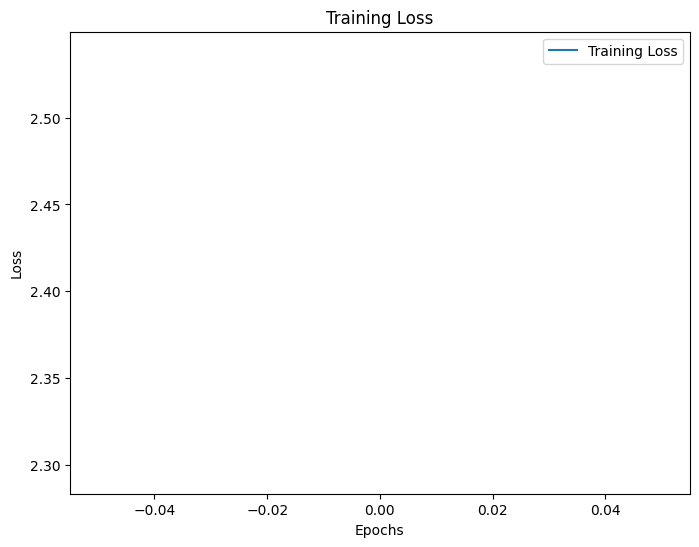

In [10]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer, TextDataset, DataCollatorForLanguageModeling
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
import torch
import matplotlib.pyplot as plt


tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token
model = GPT2LMHeadModel.from_pretrained('gpt2')

#my dataset
file_path = 'partial_dataset.csv'
dataset = TextDataset(tokenizer=tokenizer, file_path=file_path, block_size=128)

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_batch_size = 20
epochs = 3
learning_rate = 5e-5

train_loader = DataLoader(dataset, batch_size=train_batch_size, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []

#this code (that I got help creating from ChatGPT) checks if GPU is available
#and uses it, if so. Greatly reduced runtime.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.train()

for epoch in range(epochs):
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        batch = batch.to(device)
        outputs = model(input_ids=batch, labels=batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        total_loss += loss.item()

model.eval()

input_clue = input("Enter the clue: ")
input_size = int(input("Enter the character size of the answer: "))

input_encoded = tokenizer(input_clue, return_tensors='pt', padding=True, truncation=True)

#generates prediction
generated = model.generate(
    input_ids=input_encoded['input_ids'].to(model.device),
    attention_mask=input_encoded['attention_mask'].to(model.device),
    max_length=input_size,
    num_return_sequences=1
)

decoded_output = tokenizer.decode(generated[0], skip_special_tokens=True)
print(f"Predicted word based on the clue '{input_clue}' and character size {input_size}: {decoded_output}")

train_loss = total_loss / len(train_loader)
train_losses.append(train_loss)

plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


Not only is the training loss not being mapped, but the predictive model is totally off base when it comes to understanding the limitations in it's character scope.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = dataSet_partial['Clue'].astype(str)  # Clue column as input features
y = dataSet_partial['Word'].astype(str)  # Word column as target labels

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data (clues)
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_vectorized, y_train)

# Make predictions on the test set
predictions = model.predict(X_test_vectorized)

# Calculate accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

# Visualize correct and predicted answers (you may need to adjust this based on your dataset size)
num_samples = 10
for i in range(num_samples):
    print(f"Clue: {X_test.iloc[i]}")
    print(f"Actual Word: {y_test.iloc[i]}")
    print(f"Predicted Word: {predictions[i]}")
    print("---------------------------------------------")

Accuracy: 0.006666666666666667
Clue: Blows away
Actual Word: FLOORS
Predicted Word: ATE
---------------------------------------------
Clue: See 80-Down
Actual Word: ACROSS
Predicted Word: MRI
---------------------------------------------
Clue: Fox's ___ Choice Awards
Actual Word: TEEN
Predicted Word: ARE
---------------------------------------------
Clue: Dealmaking pro
Actual Word: CLOSER
Predicted Word: STIR
---------------------------------------------
Clue: Christmas trio
Actual Word: MAGI
Predicted Word: STIR
---------------------------------------------
Clue: Souvenir for a Final Four team
Actual Word: NET
Predicted Word: ETA
---------------------------------------------
Clue: Night before
Actual Word: EVE
Predicted Word: STIR
---------------------------------------------
Clue: This very instant
Actual Word: NOW
Predicted Word: MRI
---------------------------------------------
Clue: Connery who played 007 seven times
Actual Word: SEAN
Predicted Word: MRI
-------------------------

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


X = dataSet_partial['Clue'].astype(str)
y = dataSet_partial['Word'].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

param_grid = {'C': [0.1, 1, 10, 100]}

min_samples = y_train.value_counts().min()

cv_value = max(2, min(5, min_samples))

grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=cv_value)
grid.fit(X_train_vectorized, y_train)

best_C = grid.best_params_['C']

model = LogisticRegression(max_iter=1000, C=best_C)
model.fit(X_train_vectorized, y_train)

predictions = model.predict(X_test_vectorized)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy after tuning: {accuracy}")

num_samples = 10
for i in range(num_samples):
    print(f"Clue: {X_test.iloc[i]}")
    print(f"Actual Word: {y_test.iloc[i]}")
    print(f"Predicted Word: {predictions[i]}")
    print("---------------------------------------------")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Accuracy after tuning: 0.023333333333333334
Clue: Blows away
Actual Word: FLOORS
Predicted Word: ATE
---------------------------------------------
Clue: See 80-Down
Actual Word: ACROSS
Predicted Word: LEMON
---------------------------------------------
Clue: Fox's ___ Choice Awards
Actual Word: TEEN
Predicted Word: YEA
---------------------------------------------
Clue: Dealmaking pro
Actual Word: CLOSER
Predicted Word: VET
---------------------------------------------
Clue: Christmas trio
Actual Word: MAGI
Predicted Word: HAGS
---------------------------------------------
Clue: Souvenir for a Final Four team
Actual Word: NET
Predicted Word: LEI
---------------------------------------------
Clue: Night before
Actual Word: EVE
Predicted Word: TWAS
---------------------------------------------
Clue: This very instant
Actual Word: NOW
Predicted Word: FLOOR
---------------------------------------------
Clue: Connery who played 007 seven times
Actual Word: SEAN
Predicted Word: HEPTA
-------

In [45]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = dataSet_partial['Clue']
y = dataSet_partial['Word']

X_encoded = vectorizer.fit_transform(X).toarray()

character_size = dataSet_partial['Word'].apply(len)

X_processed = pd.DataFrame(X_encoded, columns=vectorizer.get_feature_names_out())
X_processed['Character_Size'] = character_size.values

model = LogisticRegression(max_iter=1000)
model.fit(X_processed, y)

user_input_clue = input("Enter the clue: ")
user_input_size = int(input("Enter the character size of the answer: "))

user_input_encoded = vectorizer.transform([user_input_clue]).toarray()

user_input_df = pd.DataFrame(user_input_encoded, columns=vectorizer.get_feature_names_out())
user_input_df['Character_Size'] = user_input_size

predicted_word = model.predict(user_input_df)

print(f"Predicted word based on the clue '{user_input_clue}' and character size {user_input_size}: {predicted_word[0]}")

Enter the clue: Love to pieces
Enter the character size of the answer: 5
Predicted word based on the clue 'Love to pieces' and character size 5: STIR


Epoch 1/20
75/75 [==============================] - 7s 9ms/step - loss: -69.5405 - accuracy: 0.0000e+00 - val_loss: -369.7341 - val_accuracy: 0.0000e+00
Epoch 2/20
75/75 [==============================] - 0s 4ms/step - loss: -676.7385 - accuracy: 4.1667e-04 - val_loss: -968.0630 - val_accuracy: 0.0000e+00
Epoch 3/20
75/75 [==============================] - 0s 4ms/step - loss: -1285.8771 - accuracy: 4.1667e-04 - val_loss: -1566.1836 - val_accuracy: 0.0000e+00
Epoch 4/20
75/75 [==============================] - 0s 4ms/step - loss: -1896.6277 - accuracy: 4.1667e-04 - val_loss: -2166.4683 - val_accuracy: 0.0000e+00
Epoch 5/20
75/75 [==============================] - 0s 5ms/step - loss: -2508.4236 - accuracy: 4.1667e-04 - val_loss: -2765.2363 - val_accuracy: 0.0000e+00
Epoch 6/20
75/75 [==============================] - 0s 5ms/step - loss: -3120.8062 - accuracy: 4.1667e-04 - val_loss: -3365.8638 - val_accuracy: 0.0000e+00
Epoch 7/20
75/75 [==============================] - 1s 9ms/step - los

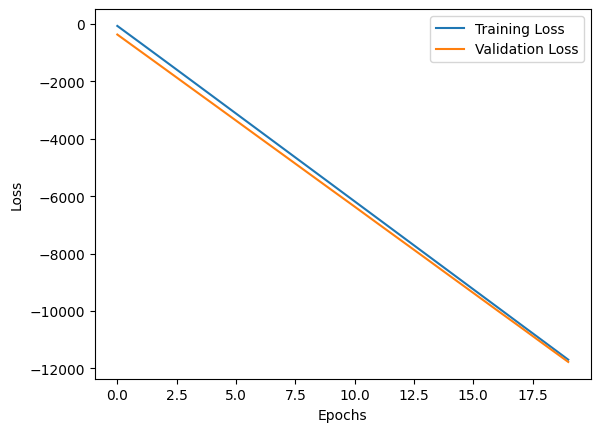

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the data
X = dataSet_partial['Clue']
y = dataSet_partial['Word']

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_encoded = vectorizer.fit_transform(X).toarray()

character_size = dataSet_partial['Word'].apply(len)

X_processed = pd.DataFrame(X_encoded, columns=vectorizer.get_feature_names_out())
X_processed['Character_Size'] = character_size.values

# Encode the labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Build a logistic regression model using Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(X_train.shape[1],))
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plotting the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Epoch 1/20
75/75 [==============================] - 3s 9ms/step - loss: 11.7832 - accuracy: 4.1667e-04 - val_loss: -15.9138 - val_accuracy: 0.0017
Epoch 2/20
75/75 [==============================] - 0s 6ms/step - loss: 23.4797 - accuracy: 0.0000e+00 - val_loss: -15.9634 - val_accuracy: 0.0017
Epoch 3/20
75/75 [==============================] - 1s 7ms/step - loss: 23.1560 - accuracy: 4.1667e-04 - val_loss: -16.0128 - val_accuracy: 0.0017
Epoch 4/20
75/75 [==============================] - 0s 6ms/step - loss: 21.0853 - accuracy: 4.1667e-04 - val_loss: -16.0625 - val_accuracy: 0.0017
Epoch 5/20
75/75 [==============================] - 0s 6ms/step - loss: 21.4658 - accuracy: 0.0000e+00 - val_loss: -16.1119 - val_accuracy: 0.0017
Epoch 6/20
75/75 [==============================] - 0s 6ms/step - loss: 21.1728 - accuracy: 4.1667e-04 - val_loss: -16.1609 - val_accuracy: 0.0017
Epoch 7/20
75/75 [==============================] - 1s 7ms/step - loss: 27.0308 - accuracy: 0.0000e+00 - val_loss: -16

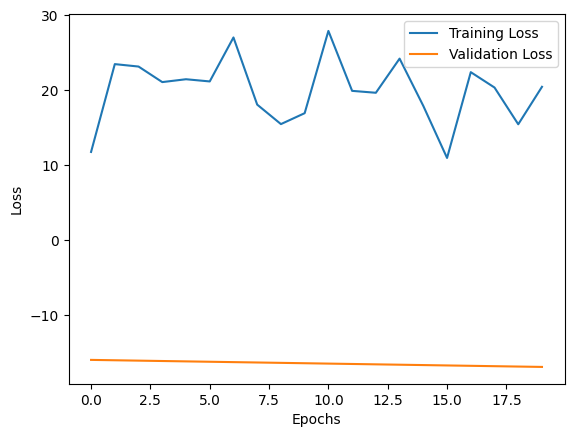

In [70]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

# Load the data
X = dataSet_partial['Clue']
y = dataSet_partial['Word']

# Vectorize the text data
vectorizer = TfidfVectorizer()
X_encoded = vectorizer.fit_transform(X).toarray()

character_size = dataSet_partial['Word'].apply(len)

X_processed = pd.DataFrame(X_encoded, columns=vectorizer.get_feature_names_out())
X_processed['Character_Size'] = character_size.values

# Convert the target labels to numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42)

X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

# Build and compile the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00000001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)


# Plotting the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()